In [1]:
DATA_PATH = r"../experiments/xor_multiple_results_100-100.json"

In [3]:
from collections import Counter, defaultdict
import json

from matplotlib import pyplot as plt
import numpy as np


def load_and_categorize_results(filename):
    """Load results and categorize into perfect and imperfect solutions"""
    with open(filename, 'r') as f:
        data = json.load(f)
    
    params = data['parameters']
    results = data['results']
    
    perfect = [r for r in results if r['perfect_found']]
    imperfect = [r for r in results if not r['perfect_found']]
    
    return params, perfect, imperfect

def parse_individual(ind_str):
    """Parse individual string representation"""
    # Replace the labels to make it eval-compatible
    modified_str = ind_str.replace('Individual[Head:', '{"Head":')
    modified_str = modified_str.replace('|Tail:', ', "Tail":')
    modified_str = modified_str.replace('|Weights:', ', "Weights":')
    modified_str = modified_str.replace('|Biases:', ', "Biases":')
    
    # Only replace the last ] with }
    if modified_str.endswith(']'):
        modified_str = modified_str[:-1] + '}'
    
    # Use eval to parse the dictionary
    ind_dict = eval(modified_str)
    
    return {
        'head': ind_dict['Head'],
        'tail': ind_dict['Tail'],
        'weights': ind_dict['Weights'],
        'biases': ind_dict['Biases'],
        'expression': ind_dict['Head'] + ind_dict['Tail']
    }

def get_effective_chromosome(ind_str, head_length):
    """Extract the effective (active) parts of the chromosome"""
    ind = parse_individual(ind_str)
    expression = ind['expression']
    
    # Get arity for each function
    arity_map = {
        'add': 2, 'subtract': 2, 'multiply': 2,
        'add3': 3, 'subtract3': 3,
        'relu': 2, 'tanh': 2, 'sigmoid': 2,
        'relu3': 3, 'tanh3': 3, 'sigmoid3': 3,
        'relu1': 1, 'tanh1': 1, 'sigmoid1': 1,
        'and_f': 2, 'or_f': 2, 'not_f': 1,
        'abs_diff': 2,
        'x0': 0, 'x1': 0
    }
    
    # Mirror the Network._build_tree logic
    if not expression or expression[0] not in arity_map:
        return {
            'active_expression': [],
            'active_weights': [],
            'active_biases': [],
            'active_indices': []
        }
    
    # Track active indices
    active_indices = set()
    root_idx = 0
    active_indices.add(root_idx)
    
    # Queue tracks (parent_idx, remaining_children)
    queue = []
    if expression[root_idx] in arity_map:
        arity = arity_map[expression[root_idx]]
        if arity > 0:
            queue.append((root_idx, arity))
    
    expr_idx = 1
    edge_count = 0  # Count edges for weights
    
    while queue and expr_idx < len(expression):
        parent_idx, remaining = queue.pop(0)
        
        if remaining > 0:
            # This position is active
            active_indices.add(expr_idx)
            edge_count += 1  # Each child connection needs a weight
            
            # Add to queue if it's a function
            if expr_idx < len(expression) and expression[expr_idx] in arity_map:
                child_arity = arity_map[expression[expr_idx]]
                if child_arity > 0:
                    queue.append((expr_idx, child_arity))
            
            # Update counters
            expr_idx += 1
            
            # Re-queue parent if more children needed
            if remaining > 1:
                queue.insert(0, (parent_idx, remaining - 1))
    
    # Extract active parts
    active_indices = sorted(active_indices)
    active_expression = [expression[i] for i in active_indices]
    
    # Weights needed = number of edges created
    active_weights = ind['weights'][:edge_count] if edge_count > 0 else []
    
    # Biases needed = number of function nodes
    bias_count = sum(1 for i in active_indices 
                     if expression[i] in arity_map and arity_map[expression[i]] > 0)
    active_biases = ind['biases'][:bias_count] if bias_count > 0 else []
    
    return {
        'active_expression': active_expression,
        'active_weights': active_weights,
        'active_biases': active_biases,
        'active_indices': active_indices
    }
    
def analyze_perfect_solutions(filename):
    """Analyze perfect solutions focusing on effective chromosomes"""
    params, perfect, imperfect = load_and_categorize_results(filename)
    
    # Data structures for analysis
    all_solutions = []
    node_positions = defaultdict(list)  # position -> list of nodes
    node_frequencies = defaultdict(int)  # node type -> count
    weights_by_position = defaultdict(list)  # position -> list of weights
    biases_by_function = defaultdict(list)  # function type -> list of biases
    
    for sol in perfect:
        ind_str = sol['best_individual']['expression']
        effective = get_effective_chromosome(ind_str, params['head_length'])
        
        # Store solution data
        solution_data = {
            'perfect': True,
            'iteration': sol['iteration'],
            'generations': sol['generations'],
            'active_nodes': effective['active_expression'],
            'active_weights': effective['active_weights'],
            'active_biases': effective['active_biases'],
            'active_indices': effective['active_indices']
        }
        all_solutions.append(solution_data)
        
        # Node positions and frequencies
        for pos, node in enumerate(effective['active_expression']):
            node_positions[pos].append(node)
            node_frequencies[node] += 1
        
        # Weights by position
        for pos, weight in enumerate(effective['active_weights']):
            weights_by_position[pos].append(weight)
        
        # Biases by function type
        func_idx = 0
        for node in effective['active_expression']:
            if node in ['relu', 'tanh', 'sigmoid', 'add', 'subtract', 'multiply', 
                        'and_f', 'or_f', 'not_f', 'add3', 'relu3', 'tanh3', 'sigmoid3',
                        'relu1', 'tanh1', 'sigmoid1', 'abs_diff']:
                if func_idx < len(effective['active_biases']):
                    biases_by_function[node].append(effective['active_biases'][func_idx])
                    func_idx += 1
    
    return {
        'params': params,
        'solutions': all_solutions,
        'node_positions': dict(node_positions),
        'node_frequencies': dict(node_frequencies),
        'weights_by_position': dict(weights_by_position),
        'biases_by_function': dict(biases_by_function),
        'perfect_count': len(perfect),
        'imperfect_count': len(imperfect)
    }

def plot_summary_grid(results, figsize=(16, 10)):
    """Create 2x2 grid of summary plots"""
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # 1. Generation Distribution (top left)
    ax1 = axes[0, 0]
    generations = [sol['generations'] for sol in results['solutions']]
    
    ax1.hist(generations, bins=20, edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Generations to Solution')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Generations Required')
    ax1.axvline(np.mean(generations), color='red', linestyle='--', 
                label=f'Mean: {np.mean(generations):.1f}')
    ax1.axvline(np.median(generations), color='green', linestyle='--',
                label=f'Median: {np.median(generations):.0f}')
    
    # Add statistics box
    stats_text = f'Min: {np.min(generations)}\nMax: {np.max(generations)}\nStd: {np.std(generations):.1f}'
    ax1.text(0.7, 0.95, stats_text, transform=ax1.transAxes, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
             verticalalignment='top')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Node Frequencies (top right)
    ax2 = axes[0, 1]
    node_freq = results['node_frequencies']
    
    # Sort by frequency
    sorted_nodes = sorted(node_freq.items(), key=lambda x: x[1], reverse=True)
    nodes = [x[0] for x in sorted_nodes]
    frequencies = [x[1] for x in sorted_nodes]
    
    # Color code by type
    colors = []
    for node in nodes:
        if node in ['x0', 'x1']:
            colors.append('lightgreen')
        elif node in ['add', 'subtract', 'multiply', 'add3']:
            colors.append('lightblue')
        elif node in ['sigmoid', 'tanh', 'relu', 'sigmoid1', 'tanh1', 'relu1', 
                      'sigmoid3', 'tanh3', 'relu3']:
            colors.append('lightcoral')
        elif node in ['and_f', 'or_f', 'not_f']:
            colors.append('lightyellow')
        else:
            colors.append('lightgray')
    
    x_pos = np.arange(len(nodes))
    ax2.bar(x_pos, frequencies, color=colors, edgecolor='black')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(nodes, rotation=45, ha='right')
    ax2.set_xlabel('Node Type')
    ax2.set_ylabel('Frequency in Effective Trees')
    ax2.set_title('Overall Node Usage Frequency (Effective Trees Only)')
    ax2.grid(True, axis='y', alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='lightgreen', edgecolor='black', label='Inputs'),
        Patch(facecolor='lightblue', edgecolor='black', label='Arithmetic'),
        Patch(facecolor='lightcoral', edgecolor='black', label='Activation'),
        Patch(facecolor='lightyellow', edgecolor='black', label='Logical')
    ]
    ax2.legend(handles=legend_elements, loc='upper right')
    
    # 3. Chromosome Length Distribution (bottom left)
    ax3 = axes[1, 0]
    chromosome_lengths = [len(sol['active_nodes']) for sol in results['solutions']]
    
    # Get unique lengths and their counts
    unique_lengths, counts = np.unique(chromosome_lengths, return_counts=True)
    
    # Create bar chart instead of histogram for discrete data
    ax3.bar(unique_lengths, counts, width=0.8, edgecolor='black', alpha=0.7, color='mediumpurple')
    ax3.set_xlabel('Effective Chromosome Length (Active Nodes)')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Effective Chromosome Lengths')
    
    # Set x-axis to show only integer values that exist in the data
    ax3.set_xticks(unique_lengths)
    ax3.set_xlim(min(unique_lengths) - 0.5, max(unique_lengths) + 0.5)
    
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Empty slot (bottom right)
    axes[1, 1].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_node_position_frequencies(results, figsize=(18, 11)):
    """Plot node frequencies at each position in the effective tree"""
    node_positions = results['node_positions']
    max_position = max(node_positions.keys())
    
    # Get all unique nodes across all positions
    all_nodes = set()
    for nodes in node_positions.values():
        all_nodes.update(nodes)
    all_nodes = sorted(list(all_nodes))
    
    # Calculate grid dimensions
    cols = 4  # charts per row
    rows = (max_position + 1 + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    
    # Get y-axis limit from position 0
    if 0 in node_positions:
        counter0 = Counter(node_positions[0])
        max_count = max(counter0.values()) if counter0 else 1
        ylim = (0, max_count * 1.1)  # Add 10% padding
    else:
        ylim = None
    
    for pos in range(max_position + 1):
        ax = axes[pos]
        
        if pos in node_positions:
            # Count frequencies
            counter = Counter(node_positions[pos])
            
            # Get counts for all nodes (0 if not present)
            counts = [counter.get(node, 0) for node in all_nodes]
            
            # Create bar chart
            x = np.arange(len(all_nodes))
            ax.bar(x, counts)
            ax.set_xticks(x)
            ax.set_xticklabels(all_nodes, rotation=45, ha='right')
            ax.set_ylabel('Count')
            ax.set_title(f'Position {pos}')
            ax.grid(axis='y', alpha=0.3)
            
            # Set consistent y-axis limit
            if ylim:
                ax.set_ylim(ylim)
        else:
            ax.set_visible(False)
    
    # Hide unused subplots
    for i in range(max_position + 1, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [4]:
results = analyze_perfect_solutions(DATA_PATH)
    
# Print summary
print(f"Total runs: {results['perfect_count'] + results['imperfect_count']}")
print(f"Perfect solutions: {results['perfect_count']}")
print(f"Success rate: {100 * results['perfect_count'] / (results['perfect_count'] + results['imperfect_count']):.1f}%")

Total runs: 100
Perfect solutions: 100
Success rate: 100.0%


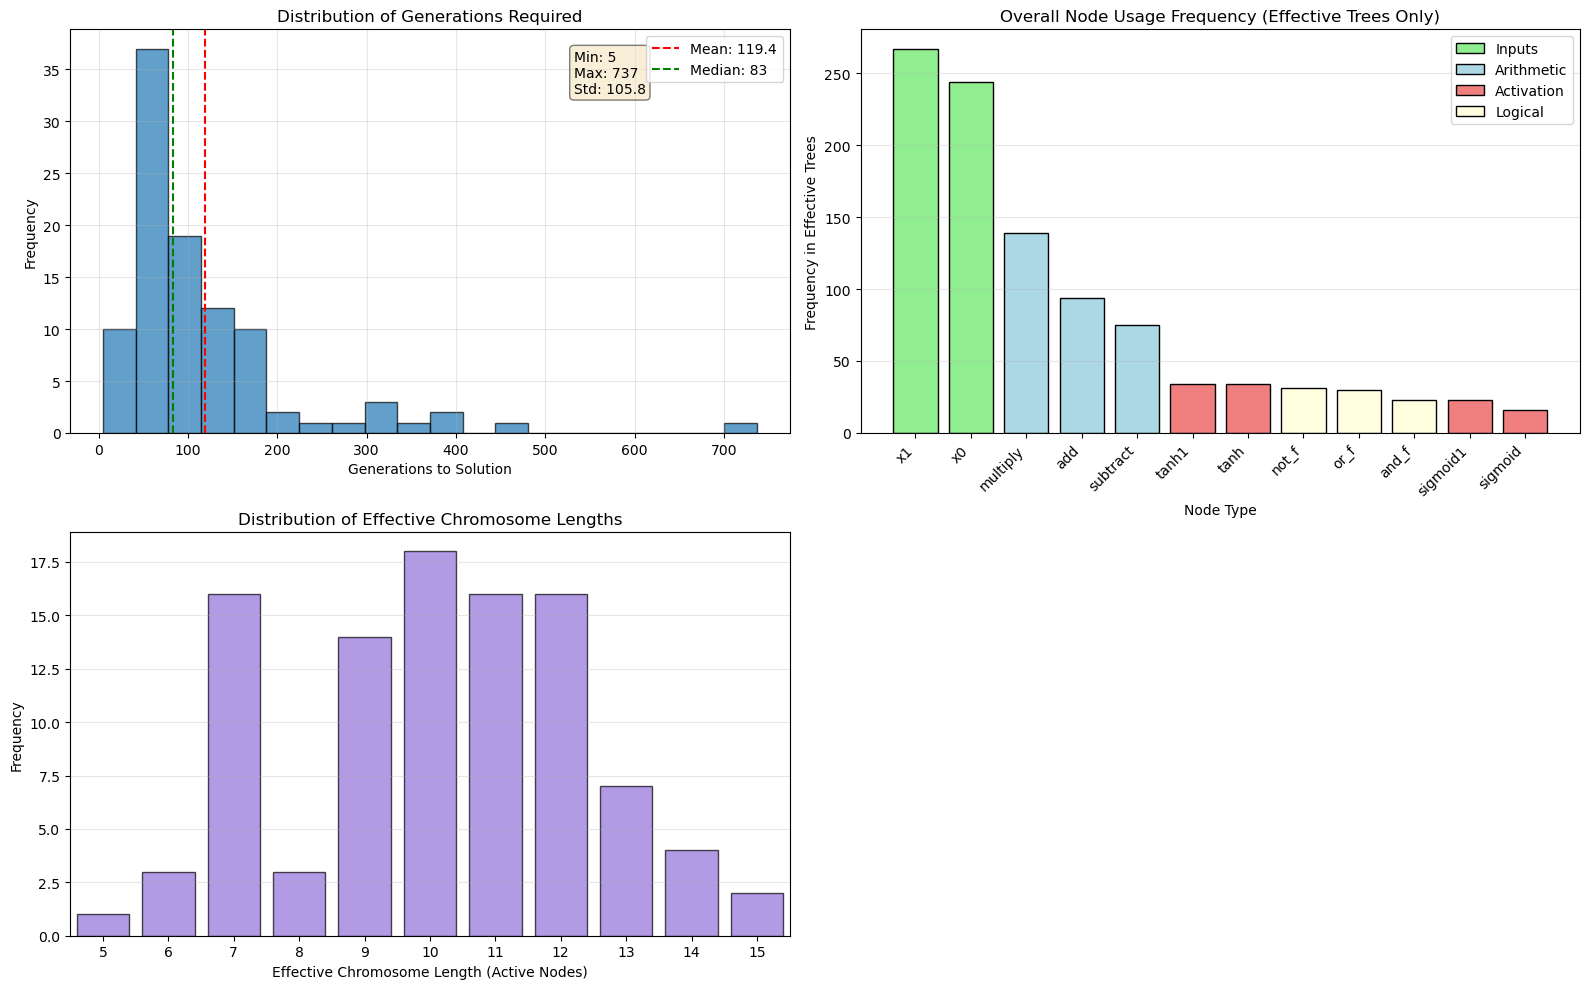

In [5]:
plot_summary_grid(results)

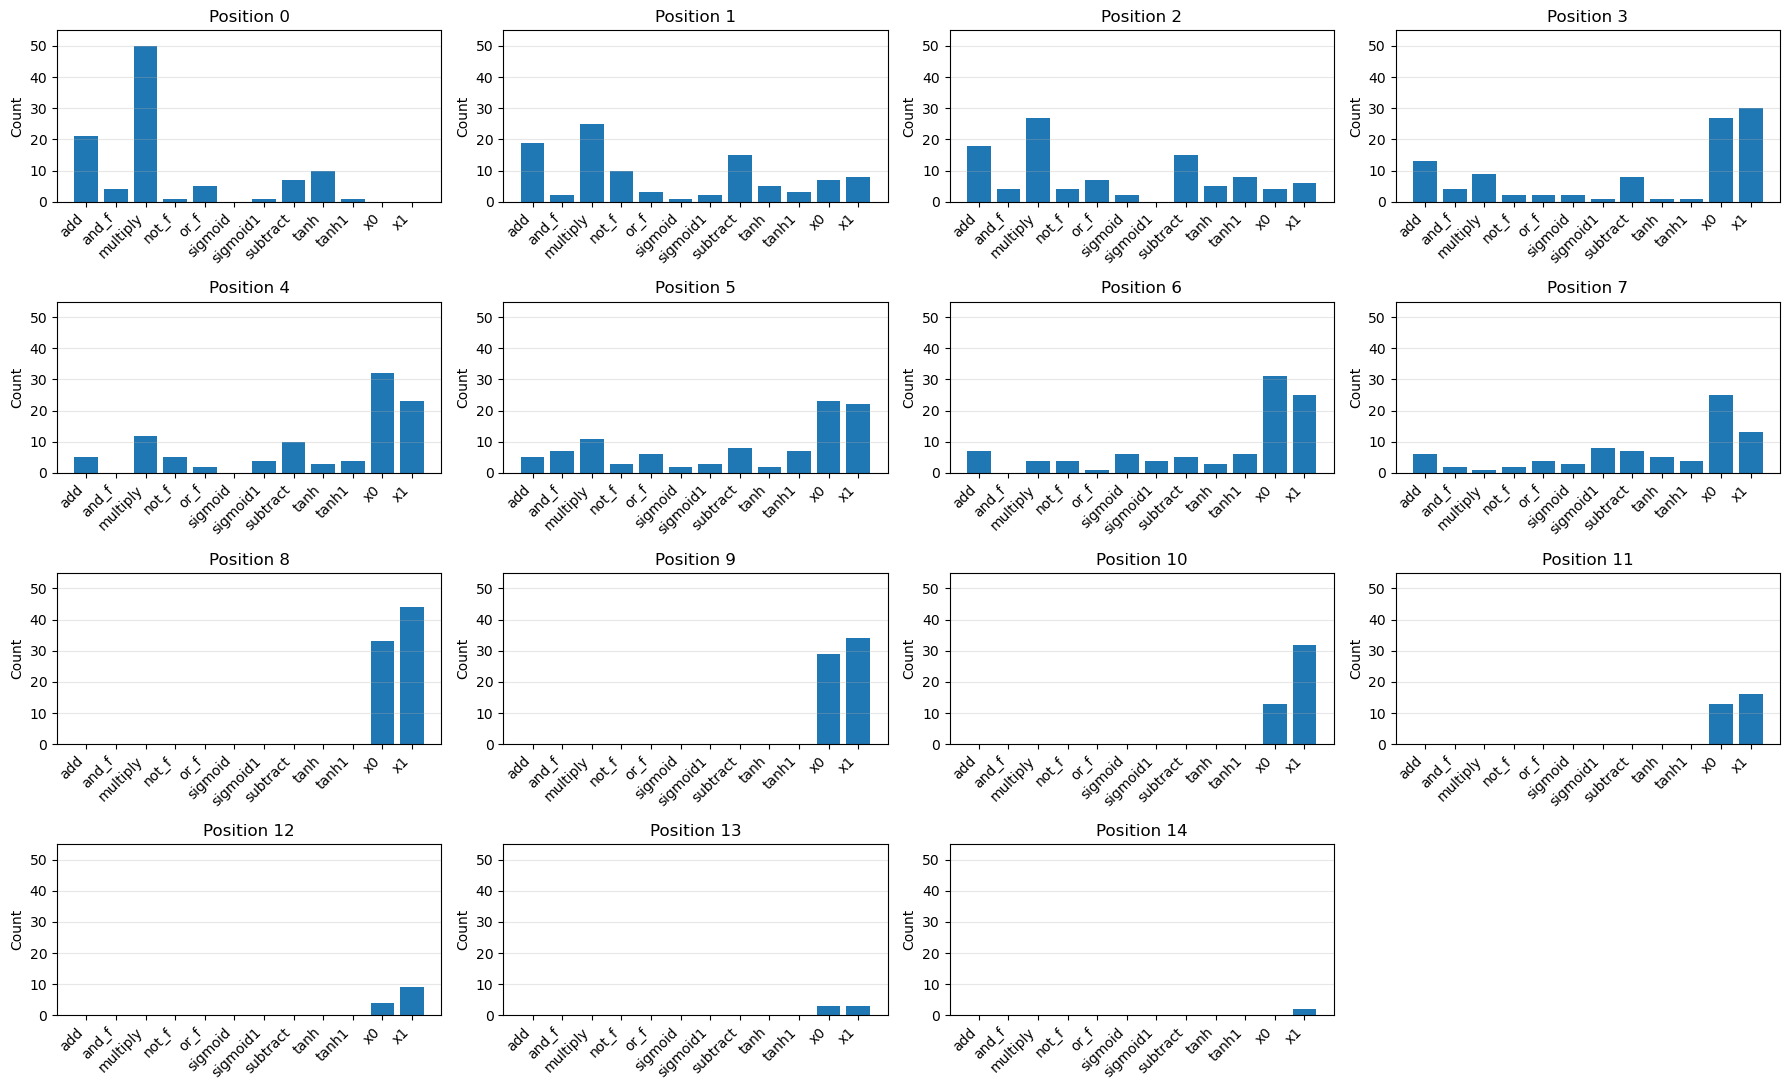

In [6]:
plot_node_position_frequencies(results)

In [7]:
four_node_solutions = [sol for sol in results['solutions'] if len(sol['active_nodes']) == 5]

print(f"Found {len(four_node_solutions)} solutions with only 5 nodes\n")

# Display the first one
if four_node_solutions:
    example = four_node_solutions[0]
    print(f"Iteration {example['iteration']} - Generation {example['generations']}:")
    print(f"Active nodes: {example['active_nodes']}")
    print(f"Active indices in original expression: {example['active_indices']}")

Found 1 solutions with only 5 nodes

Iteration 23 - Generation 121:
Active nodes: ['multiply', 'not_f', 'tanh1', 'x1', 'x0']
Active indices in original expression: [0, 1, 2, 3, 4]
